In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from radio_beam import Beam
from astropy.nddata.utils import Cutout2D

from matplotlib.ticker import MultipleLocator

import numpy as np
import astropy.units as u
from scipy import stats

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.size': 3,
                     'xtick.major.size': 6,
                     'ytick.minor.size': 3,
                     'ytick.major.size': 6,})

In [42]:
from molecular_columns import col_h13cop, col_dcop

def Ncol_C18O(TdV, Tex=10*u.K):
    """
    Column density calculation using expression from 
    E. Curtis et al. (2010) doi:10.1111/j.1365-2966.2009.15658.x
    It takes the integrated intensity and returns the C18O column density
    in units of cm^-2
    """
    if TdV.unit != (u.K * u.km / u.s):
        print('Unit of integrated intensity is not K km/s, please modify accordingly')
        return np.nan
    return 5e12 * (Tex/u.K) * np.exp(31.6*u.K/Tex) * (TdV/(u.K*u.km/u.s)) * u.cm**-2

file_yso = 'catalogue/NGC1333_protostar_list.txt'

file_N_H2 = 'data/NGC1333_SE_H2.fits'
file_TdV_DCOp = 'data/NGC1333_DCOp_matched_TdV.fits'
file_TdV_H13COp = 'data/NGC1333_H13COp_matched_TdV.fits'
file_TdV_C18O = 'data/NGC1333_C18O_matched_TdV.fits'

file_Ncol_DCOp_HCOp = 'data/NGC1333_DCOp_HCOp_ratio_coldens.fits'

file_SNR_DCOp = 'data/NGC1333_DCOp_SNR.fits'
file_SNR_HCOp = 'data/NGC1333_H13COp_SNR.fits'

file_fd = 'data/NGC1333_SE_fd.fits'
file_n_H2 = 'data/NGC1333_SE_n_H2.fits'

file_n_H2_zeta_L1544 = 'data/L1544_model_lowCRIR_1e6yr.dat'

X_12CO = 1.5e-4
# 12CO / 13CO = 70
# 13CO / C18O = 8.4
X_C18O = X_12CO / (8.4 * 70)
R_12CO_C18O = 8.4 * 70

# center and size for cutouts
ra0 = 52.2923239
dec0 = 31.2304113
width = 0.1010000
height = 0.1150000

# Contour levels for N(H_2) in to overplot in figures
levels_H2 = np.arange(22.2, 23.7, 0.5)

# col_pos = [0.55, 0.3, 0.3, 0.025]
col_pos = [0.575, 0.15, 0.35, 0.025]

xpos_lab1, ypos_lab1 = (0.0225, 0.9)
xpos_lab2, ypos_lab2 = (0.0225, 0.85)
xpos_lab3, ypos_lab3 = (0.0225, 0.80)

my_figsize = (5, 5)

cutout_size = u.Quantity((height, width), u.deg)
position = SkyCoord(ra0 * u.deg, dec0 * u.deg, frame='fk5')
# bottom-right corner of map
dx_index = np.array([-1, -1, 1, 1, -1]) * width * 0.5
dy_index = np.array([-1, 1, 1, -1, -1]) * height * 0.5
position_corner_NOEMA = position.spherical_offsets_by(dx_index * u.deg, dy_index * u.deg)  

beam_pos = SkyCoord("03h29m23.2s", "31d17m2s", frame='fk5')
beam_pos_big = SkyCoord("03h29m22.0s", "31d16m45s", frame='fk5')
scalebar_pos = SkyCoord("03h28m59.5s", "31d10m50s", frame='fk5')

scalebar_pos_ngc1333 = SkyCoord("03h28m20.0s", "31d05m00s", frame='fk5')

file_xe_fd = 'data/NGC1333_xe_fd.fits'

N_H2 = fits.getdata(file_N_H2) * u.cm**-2
hdu_log10_h2 = fits.PrimaryHDU(np.log10(fits.getdata(file_N_H2)), 
                               fits.getheader(file_N_H2))

C18O_TdV, hd_C18O = fits.getdata(file_TdV_C18O, header=True)
Tex_C18O = 12*u.K
N_C18O_12K = Ncol_C18O(C18O_TdV*u.K*u.km/u.s, Tex=12*u.K)
N_C18O_15K = Ncol_C18O(C18O_TdV*u.K*u.km/u.s, Tex=15*u.K)
# 

N_CO = N_C18O_12K * R_12CO_C18O
HCOp_TdV, hd_TdV = fits.getdata(file_TdV_H13COp, header=True)
DCOp_TdV, hd_TdV_DCOp = fits.getdata(file_TdV_DCOp, header=True)

# H12CO+ / H13CO+ = 70
HCOp_Ncol = col_h13cop.H13COp_thin(J_up=1, Tex=10.0*u.K, TdV=HCOp_TdV*u.K*u.km/u.s) * 70.0
DCOp_Ncol = col_dcop.DCOp_thin(J_up=1, Tex=10.0*u.K, TdV=DCOp_TdV*u.K*u.km/u.s)

SNR_DCOp = fits.getdata(file_SNR_DCOp)
SNR_HCOp = fits.getdata(file_SNR_HCOp)

bad_SNR_DCOp = (SNR_DCOp < 7.5)
bad_SNR_HCOp = (SNR_HCOp < 7.5)
bad_SNR_DCOp_HCOp = (SNR_HCOp < 7.5) | (SNR_DCOp < 7.5)

R_H = HCOp_Ncol.to(u.cm**-2) / N_CO
R_D = DCOp_Ncol / HCOp_Ncol

R_H[bad_SNR_HCOp] = np.nan
R_D[bad_SNR_DCOp_HCOp] = np.nan

hdu_R_D = fits.PrimaryHDU(R_D, hd_TdV_DCOp)
hdu_R_H = fits.PrimaryHDU(R_H, hd_TdV)

n_H2_mean = 1e3

print(np.nanmean(N_CO))

1.0415168103250167e+18 1 / cm2


/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_94609/1031395484.py:72: RuntimeWarning: invalid value encountered in log10
  hdu_log10_h2 = fits.PrimaryHDU(np.log10(fits.getdata(file_N_H2)),


In [35]:
distance = 300. # pc

ra_yso, dec_yso = np.loadtxt(file_yso, unpack=True)
marker_size = 50

def load_cutout(file_in, is_hdu=False):
    """
    Convenience function to load a FITS file, or an existing HDU, 
    and to generate a cutout following the requested center and sizes.
    
    params:
    
    file_in : FITS file name to be loaded (if is_hdu=False). If is_hdu=True, 
              the file_in represents a valid HDU to be used.
    is_hdu : Boolean parameter. It controls what is passed to the function.
    
    Return:
    It returns the HDU of the cutout defined by the global variables: position and cutout_size.
    """
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in.copy()
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_noema_wcsaxes(ax, hdu, label_col='black', contour_h2=False, big_beam=False):
    # get axes coordinates
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    # Sets formatting
    ra_ax.set_major_formatter('hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    # set ticks spacing and minor tick paramters
    ra_ax.set_ticks(spacing=8 * 15 * u.arcsec, color=label_col)
    dec_ax.set_ticks(spacing=2 * u.arcmin, color=label_col)
    ra_ax.set_minor_frequency(4)
    dec_ax.set_minor_frequency(4)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.tick_params(color=label_col)
    #
    ax.autoscale(enable=False)
    ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
                 linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))
    # H2 column density contours
    if contour_h2:
        ax.contour(hdu_log10_h2.data, levels=levels_H2, 
                   transform=ax.get_transform(WCS(hdu_log10_h2.header)), 
                   colors=label_col, linewidths=1, alpha=0.5)
    # Add beamsize
    my_beam = Beam.from_fits_header(hdu.header)
    if big_beam:
        xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos_big)
    else:
        xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos)
    pixscale = np.abs(hdu.header['cdelt1']) * u.deg
    ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
    ellipse_artist.set_color(label_col)
    _ = ax.add_artist(ellipse_artist)      
    
    # Scalebar
    length = (5e3*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
    ax.plot([scalebar_pos.ra.deg, (scalebar_pos.ra - length).deg]*u.deg,
        [(scalebar_pos.dec).deg]*2*u.deg,
        label_col, transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
    ax.text((scalebar_pos.ra - length / 2).deg, (scalebar_pos.dec - 0.004*u.deg).deg,
        "5,000 au", color=label_col, transform=ax.get_transform('fk5'), ha='center')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')


## Spitzer image of NGC 1333
The NGC 1333 region was mapped by the c2d project with Spitzer. It is a nice figure to show the area mapped with NOEMA and 30-m.

In [36]:
image_r, hd_NGC1333 = fits.getdata('data/NGC1333_IRAC4.fits', header=True)
image_g = fits.getdata('data/NGC1333_IRAC2.fits')
image_b = fits.getdata('data/NGC1333_IRAC1.fits')
#
vmin = 8.0; vmax = 18.0
image_r = np.maximum(np.minimum((image_r - vmin) / (vmax - vmin), 1), 0.) * 255
image_r[np.isnan(image_r)] = 0
#
vmin = 0.1; vmax = 2.0
image_g = np.maximum(np.minimum((image_g - vmin) / (vmax - vmin), 1), 0.) * 255
image_g[np.isnan(image_g)] = 0
#
vmin = 0.0; vmax = 2.0
image_b = np.maximum(np.minimum((image_b - vmin) / (vmax - vmin), 1), 0.) * 255
image_b[np.isnan(image_b)] = 0
image_rgb = np.dstack([image_r, image_g, image_b]).astype(np.uint8)

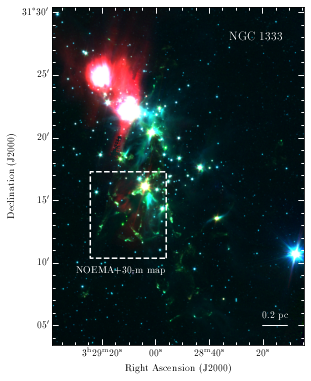

In [60]:
text_color = 'white'

wcs = WCS(hd_NGC1333)

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(image_rgb, origin='lower')

ra_ax = ax.coords[0] # lon
dec_ax = ax.coords[1] # lat
# Sets formatting
ra_ax.set_major_formatter('hh:mm:ss')
dec_ax.set_major_formatter('dd:mm')
ra_ax.display_minor_ticks(True)
dec_ax.display_minor_ticks(True)
# set ticks spacing and minor tick paramters
ra_ax.set_ticks(spacing=15 * 20 * u.arcsec, color=text_color)
dec_ax.set_ticks(spacing=5 * u.arcmin, color=text_color)
ra_ax.set_minor_frequency(4)
dec_ax.set_minor_frequency(5)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
ax.tick_params(color=text_color)
ax.autoscale(enable=False)
#
fig.text(0.7, ypos_lab1, 'NGC 1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
# Scalebar
length = (0.2*u.pc / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
ax.plot([scalebar_pos_ngc1333.ra.deg, (scalebar_pos_ngc1333.ra - length).deg]*u.deg,
    [(scalebar_pos_ngc1333.dec).deg]*2*u.deg,
    text_color, transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
ax.text((scalebar_pos_ngc1333.ra - length / 2).deg, (scalebar_pos_ngc1333.dec + 0.01*u.deg).deg,
    "0.2 pc", color=text_color, transform=ax.get_transform('fk5'), ha='center')
#
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')
#
ax.plot(position_corner_NOEMA.ra, position_corner_NOEMA.dec, color='white', 
        transform=ax.get_transform('fk5'), linestyle="--")
ax.text(position_corner_NOEMA.ra[0].deg, (position_corner_NOEMA.dec[0] - 0.02*u.deg).deg,
    "NOEMA+30-m map", color=text_color, transform=ax.get_transform('fk5'), ha='right')

plt.tight_layout()
fig.savefig('figs/NGC1333_Overall.pdf', dpi=250, bbox_inches='tight')

## Data used
### Herschel maps
We use the column density map from Herschel as a good estimate of the total H$_2$ column density.

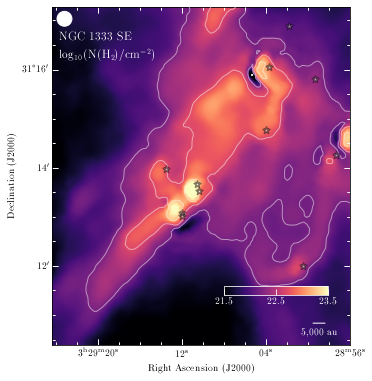

In [4]:
text_color = 'white'

# copy HDU with log_10(N(H_2))
hdu = load_cutout(hdu_log10_h2, is_hdu=True)
# hdu = hdu_log10_h2.copy()
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=21.5, vmax=23.5, origin='lower')
# im = ax.imshow(np.log10(hdu.data), cmap=cmap, vmin=21.5, vmax=23.5, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'', orientation='horizontal')
#
cbar.set_ticks([21.5, 22.5, 23.5])#
cbar.ax.xaxis.set_ticklabels([21.5, 22.5, 23.5], color=text_color)
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)
#
fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'log$_{10}$(N(H$_2$)/cm$^{-2}$)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_H2.pdf', dpi=200, bbox_inches='tight')

### JCMT
The map of the HARPS JCMT C$^{18}$O (3--2) emission is shown. This will be used to estimate the total CO column density.

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


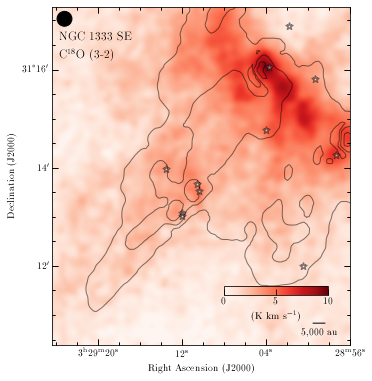

In [5]:
text_color = 'black'

hdu = load_cutout(file_TdV_C18O)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Reds').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=10, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200, bbox_inches='tight')

### NOEMA data
#### Integrated intensity maps
We show the integrated intensity maps for both transitions used, DCO$^+$ (1--0) and H$^{13}$CO$^+$ (1--0).

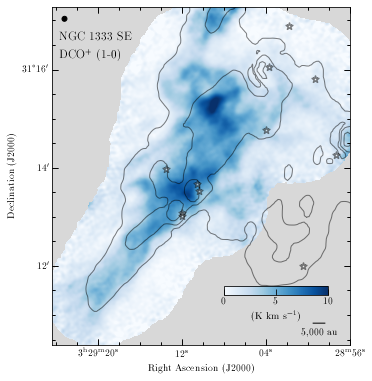

In [6]:
text_color = 'black'

hdu = load_cutout(file_TdV_DCOp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=10, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'DCO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_DCOp_TdV.pdf', dpi=200, bbox_inches='tight')

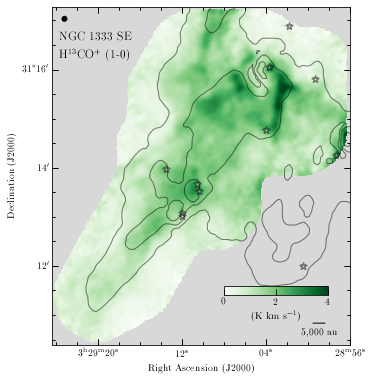

In [7]:
text_color = 'black'

hdu = load_cutout(file_TdV_H13COp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=4.0, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 2, 4])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200, bbox_inches='tight')

### DCO$^+$ and HCO$^+$ ratio
We use the derived column densities to estimate the value of the ratio, $R_D$.

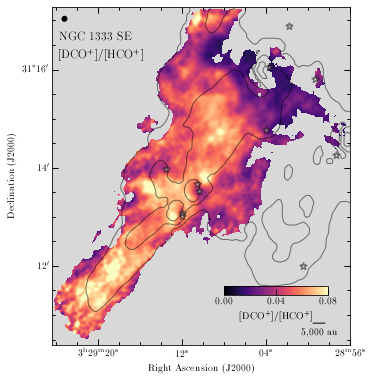

In [8]:
text_color = 'black'

hdu = load_cutout(hdu_R_D, is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=0.08, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'[DCO$^{+}$]/[HCO$^{+}$]', orientation='horizontal')
cbar.set_ticks([0, 4e-2, 8e-2])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'[DCO$^{+}$]/[HCO$^{+}$]', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_Ncol_DCOp_HCOp.pdf', dpi=200, bbox_inches='tight')

## CO Depletion
### H$_2$ and C$^{18}$O comparison: 

The H$_2$ column density is likely tracing material which is not seen by C$^{18}$O. If this is a single offset, it can be estimated as:
$$
\delta(N_{\rm H_2}) = N(H_2) - N(C^{18}O)/X_{0,18}~,
$$
where $X_{0,18}$ is the canonical abundance ($1.5\times 10^{-4} / (8.4\cdot 70) $).

The $\delta(N_{\rm H_2})$ is estimated over the range on which $N(H_2)<5\times 10^{21} {\rm cm^{-2}}$.

In [9]:
gd = (N_CO > 0.0)*(N_H2 > 10**(21.5)/u.cm**2)
gd_delta = (N_CO > 0.0) * (N_H2 > 10**(21.5)/u.cm**2) * (N_H2 < 5e21/u.cm**2)
N_CO_H2 = N_CO/X_12CO
delta_H2 = N_H2 - N_CO_H2
mean_delta_H2 = np.mean(delta_H2[gd_delta])
print(np.round(mean_delta_H2*1e-21, decimals=1)*1e21)

f_D = (N_H2 - mean_delta_H2) / N_CO_H2
f_D[~gd] = np.nan

x_line = np.array([0, 200])/u.cm**2

# hd_fd = hd_TdV.copy()
hd_fd = hdu_log10_h2.header.copy()
hd_fd['BUNIT'] = ''
hdu_fd = fits.PrimaryHDU(f_D, hd_fd)
fits.writeto(file_fd, f_D.value, hd_fd, overwrite=True)

print(np.nanmax(f_D))

1.5e+21 1 / cm2
420.3927070873461


Lets plot the comparison between the ${\rm H_2}$ column density and that derived using the C$^{18}$O. This shows how much depletion there is. Also, a red line showing the locus for the points without depletion is shown.

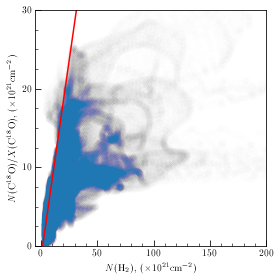

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(N_H2[gd]*1e-21, N_CO_H2[gd]*1e-21, alpha=0.005)
ax.plot(x_line, x_line - mean_delta_H2*1e-21, color='r')
ax.set_xlim(-5, 200)
ax.set_ylim(-0, 30)
ax.set_xlabel(r"$N({\rm H_2})$, ($\times 10^{21} {\rm cm^{-2}}$)")
ax.set_ylabel(r"$N({\rm C^{18}O})/X({\rm C^{18}O})$, ($\times 10^{21} {\rm cm^{-2}}$)")
#
# ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
#         transform=ax.transAxes, size=17, weight=60)

ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))

# ax.set_xticks([0.05, 0.1, 0.15, 0.2])
ax.set_yticks([0, 10, 20, 30])

plt.tight_layout()
fig.savefig('figs/NGC1333_H2_C18O_scatter.pdf', dpi=100, bbox_inches='tight')

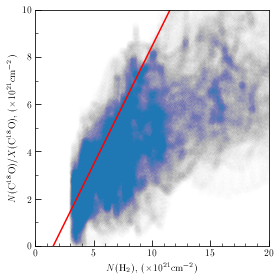

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(N_H2[gd]*1e-21, N_CO_H2[gd]*1e-21, alpha=0.002)
ax.plot(x_line, x_line - mean_delta_H2*1e-21, color='r')

ax.set_xlabel(r"$N({\rm H_2})$, ($\times 10^{21} {\rm cm^{-2}}$)")
ax.set_ylabel(r"$N({\rm C^{18}O})/X({\rm C^{18}O})$, ($\times 10^{21} {\rm cm^{-2}}$)")
#
# ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
#         transform=ax.transAxes, size=17, weight=60)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# ax.set_xticks([0.05, 0.1, 0.15, 0.2])
# ax.set_yticks([0, 10, 20, 30])
ax.set_xlim(0, 20)
ax.set_ylim(-0, 10)

plt.tight_layout()
fig.savefig('figs/NGC1333_H2_C18O_scatter_zoom.pdf', dpi=100, bbox_inches='tight')

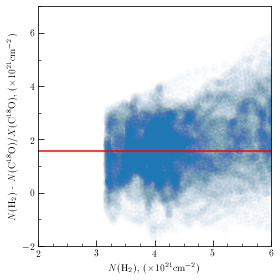

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(N_H2[gd]*1e-21, delta_H2[gd]*1e-21, alpha=0.01)

# ax.scatter(N_H2[gd]*1e-21, N_CO_H2[gd]*1e-21, alpha=0.002)
ax.plot(x_line, x_line*0.0 + mean_delta_H2*1e-21, color='r')

ax.set_xlabel(r"$N({\rm H_2})$, ($\times 10^{21} {\rm cm^{-2}}$)")
ax.set_ylabel(r"$N({\rm H_2})$ - $N({\rm C^{18}O})/X({\rm C^{18}O})$, ($\times 10^{21} {\rm cm^{-2}}$)")
#
# ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
#         transform=ax.transAxes, size=17, weight=60)

ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# ax.set_xticks([0.05, 0.1, 0.15, 0.2])
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlim(2, 6)
ax.set_ylim(-2, 7)

plt.tight_layout()
fig.savefig('figs/NGC1333_delta_H2_C18O_scatter_zoom.pdf', dpi=100, bbox_inches='tight')

Now a quick plot of the depletion fraction map.

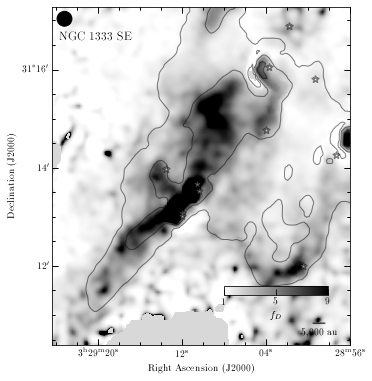

In [13]:
text_color = 'black'

hdu = load_cutout(hdu_fd, is_hdu=True)
# hdu = load_cutout(fits.PrimaryHDU((f_d), hd_d_JCMT), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='gray_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=1.0, vmax=9, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$f_D$', color=text_color)
cbar.set_ticks([1, 5, 9])
cbar.ax.xaxis.set_ticklabels([1, 5, 9], color=text_color)
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_fd.pdf', dpi=200, bbox_inches='tight')

### H$_2$ density
We estimate the density as 
\begin{equation}
 n({\rm H}_2) =  \frac{N({\rm H_2}) - \delta(N_{\rm H_2})}{depth}~,
\end{equation}
and assuming a depth of 0.4 pc.

In [14]:
n_H2 = ( (N_H2 - delta_H2) / (0.4*u.pc)).to(1./u.cm**3)
n_H2[n_H2 < 0.0] = np.nan

# hd_n_H2 = hd_TdV.copy()
hd_n_H2 = hdu_log10_h2.header.copy()
hd_n_H2['BUNIT'] = 'cm**-3'
hdu_n_H2 = fits.PrimaryHDU(n_H2, hd_n_H2)
fits.writeto(file_n_H2, n_H2.value, hd_n_H2, overwrite=True)
# plt.imshow(n_H2/1e4, origin='lower', vmin=0, vmax=3, cmap='viridis')

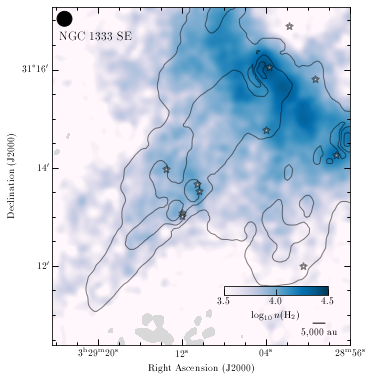

In [15]:
text_color = 'black'

hdu = load_cutout(hdu_n_H2, is_hdu=True)
# hdu = load_cutout(fits.PrimaryHDU((f_d), hd_d_JCMT), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='PuBu').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(np.log10(hdu.data.value), vmin=3.5, vmax=4.5, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\log_{10}n({\rm H_2})$', color=text_color)
# cbar.set_ticks([1, 5, 9])
# cbar.ax.xaxis.set_ticklabels([1, 5, 9], color=text_color)
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_n_H2.pdf', dpi=200, bbox_inches='tight')

## Electron Fraction map

For this we use the previous expresion, and the derived values of $R_d$ and $f_D$.

In [16]:
xe_fd = 2.7e-8 / R_D - 1.2e-6 / f_D

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


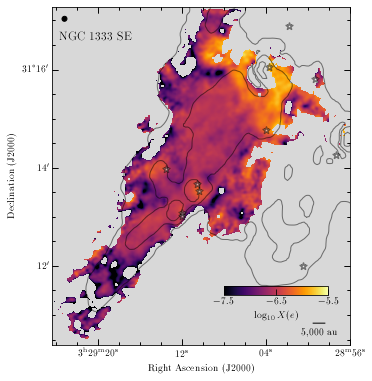

In [17]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(np.log10(xe_fd), hd_TdV), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='inferno').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-7.5, vmax=-5.5, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10} X(e)$', orientation='horizontal')
cbar.set_ticks([-7.5, -6.5, -5.5])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_xe_fd.pdf', dpi=200, bbox_inches='tight')

In [18]:
sigma_levels = np.array([0.5, 1.0, 1.5, 2.0])
sigma_levels_l = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
filled_levels = np.hstack([0, sigma_levels])  # 9000 sigmas ~ np.inf
filled_levels_l = np.hstack([0, sigma_levels_l])  # 9000 sigmas ~ np.inf
levels_norm = np.exp(-0.5 * sigma_levels ** 2)[::-1]
levels_norm_f = np.exp(-0.5 * filled_levels ** 2)[::-1]
levels_norm_l = np.exp(-0.5 * filled_levels_l ** 2)[::-1]

color_kde = ['#e41a1c', '#377eb8', '#a65628']
color_levels = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c',
                '#fd8d3c', '#fc4e2a', '#e31a1c', '#b10026']
color_levels2 = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6',
                 '#4292c6', '#2171b5', '#08519c', '#08306b']

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


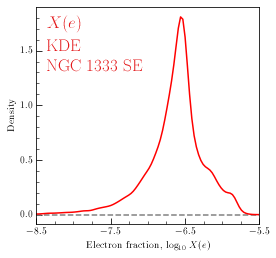

In [19]:
log_xe = np.log10(xe_fd)

xrange = np.array([-8.5, -5.5])

gd_xe = np.isfinite(log_xe)
# wt = 1 / NH3_dv[log_xe]**2
#
kde_log_xe = stats.gaussian_kde(log_xe[gd_xe])#, weights=wt)
x_sample = np.linspace(xrange[0], xrange[1], num=100)
log_xe_sample = np.reshape(kde_log_xe(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, log_xe_sample, color='red', label=r'$\sigma_v$')
#
ax.text(0.05, 0.9,  r'$X(e)$', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.8,  r'KDE', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.7,  r'NGC 1333 SE', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)

ax.set_xlabel(r"Electron fraction, $\log_{10} X(e)$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xticks([-8.5, -7.5, -6.5, -5.5])
ax.set_yticks([0, 0.5, 1, 1.5])

fig.savefig('figs/NGC1333_log_xe_KDE.pdf', dpi=100, bbox_inches='tight')

### Compare between CO depletion fraction and Electron Fraction

In [20]:
fd_min = 1.0
fd_max = 25
xe_min = -8.5
xe_max = -4.5
gd_map = np.isfinite(f_D * log_xe)
my_X = f_D[gd_map]
my_Y = log_xe[gd_map]

xx_fd_xe, yy_fd_xe = np.mgrid[fd_min:fd_max:100j, xe_min:xe_max:100j]
positions = np.vstack([xx_fd_xe.ravel(), yy_fd_xe.ravel()])
values = np.vstack([my_X, my_Y])
kernel_fd_xe = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_fd_xe(positions).T, xx_fd_xe.shape)

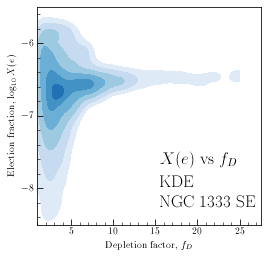

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_fd_xe, yy_fd_xe, my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())
#
ax.set_xlim([1, 27.5])
ax.set_ylim([-8.5, -5.5])
#
ax.set_xlabel(r"Depletion factor, $f_D$")
ax.set_ylabel(r"Election fraction, $\log_{10} X(e)$")
#

ax.text(0.55, 0.075,  r'NGC 1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.175,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.275,  r'$X(e)$ vs $f_D$', color='black', 
        transform=ax.transAxes, size=17, weight=60)

# ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([-8, -7, -6])
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
#
fig.savefig('figs/NGC1333_log_xe_fd_KDE.pdf', dpi=100, bbox_inches='tight')

### Compare between H$_2$ density and Electron Fraction
For this we compare the density and electron fraction relations from McKee (1989) and Caselli et al (2002), and the result from modeling L1544 (Redaelli et al. 2021).

In [22]:
from astropy.io import ascii
def ion_fraction(dens_all, do_Caselli=True):
    """
    1.3e-5 x n(H2)^{0.5}  (from McKee 1989) or 5.2e-6 x n*H2)^{0.44} 
    """
    if do_Caselli:
        xe = 5.2e-6 * (dens_all/(u.cm**-3))**-0.56
    else:
        xe = 1.3e-5 * (dens_all/(u.cm**-3))**-0.5
    return xe

data_L1544 = ascii.read(file_n_H2_zeta_L1544)

In [23]:
log_n_H2_min = 3
log_n_H2_max = 5
xe_min = -8.5
xe_max = -4.5
gd_map = np.isfinite(n_H2 * log_xe)
my_X = np.log10(n_H2[gd_map] * u.cm**3)
my_Y = log_xe[gd_map]

xx_n_H2_xe, yy_n_H2_xe = np.mgrid[log_n_H2_min:log_n_H2_max:100j, xe_min:xe_max:100j]
positions = np.vstack([xx_n_H2_xe.ravel(), yy_n_H2_xe.ravel()])
values = np.vstack([my_X, my_Y])
kernel_n_H2_xe = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_n_H2_xe(positions).T, xx_n_H2_xe.shape)

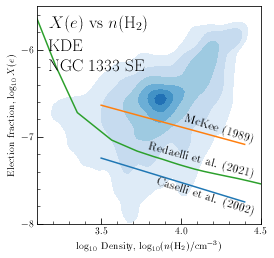

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_n_H2_xe, yy_n_H2_xe, my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())
#
ax.set_xlim([3.1, 4.5])
ax.set_ylim([-8, -5.5])

n_H2_sample = 10**(np.arange(3.5, 4.5, 0.1))/u.cm**3
#
ax.set_xlabel(r"$\log_{10}$ Density, $\log_{10}(n({\rm H_2) /cm^{-3}})$")
ax.set_ylabel(r"Election fraction, $\log_{10} X(e)$")
#
ax.text(0.05, 0.70,  r'NGC 1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.80,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.90,  r'$X(e)$ vs $n({\rm H_2})$', color='black', 
        transform=ax.transAxes, size=17, weight=60)
#
# Plot curves from models
#
ax.plot(np.log10(n_H2_sample*u.cm**3), np.log10(ion_fraction(n_H2_sample, do_Caselli=True)), label='Caselli')
ax.plot(np.log10(n_H2_sample*u.cm**3), np.log10(ion_fraction(n_H2_sample, do_Caselli=False)), label='McKee')
ax.plot(np.log10(data_L1544['n(H2)']), np.log10(data_L1544['e-']))
#
# Labels for curves
#
ax.text(0.975, 0.375,  r'McKee (1989)', color='black', rotation=-17.5,
        transform=ax.transAxes, size=12, weight=60, horizontalalignment='right')
ax.text(0.975, 0.22,  r'Redaelli et al. (2021)', color='black', rotation=-15,
        transform=ax.transAxes, size=12, weight=60, horizontalalignment='right')
ax.text(0.975, 0.04750,  r'Caselli et al. (2002)', color='black', rotation=-17.5,
        transform=ax.transAxes, size=12, weight=60, horizontalalignment='right')
#
# Setup for Ticks
#
ax.set_xticks([3.5, 4, 4.5])
ax.set_yticks([-8, -7, -6])
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
#
fig.savefig('figs/NGC1333_log_xe_log_n_H2_KDE.pdf', dpi=100, bbox_inches='tight')

## Cosmic Ray ionization rate

$\zeta = [7.5\times 10^{-4} X(e) + \frac{4.6\times 10^{-10}}{f_D}] 
X(e)\, n(H_2)\, R_H$ 

Where $R_H = [{\rm HCO}^+]/[{\rm CO}]$. At this moment, I have derived the CO column density, but not the HCO$^+$. So, I will use a $R_H$ that has a mean of $\sim 10^{-5.5}$.

Also, we will use the density derived from Herschel and also assume a density of $10^3$ cm$^{-3}$, variable defined at the top.

In [25]:
zeta_mean_n = (7.5e-4 * xe_fd + 4.6e-10/f_D) * xe_fd * R_H * n_H2_mean
zeta = (7.5e-4 * xe_fd + 4.6e-10/f_D) * xe_fd * R_H * (n_H2 * u.cm**3)
print(np.nanmean(zeta))

1.4986343102888254e-16


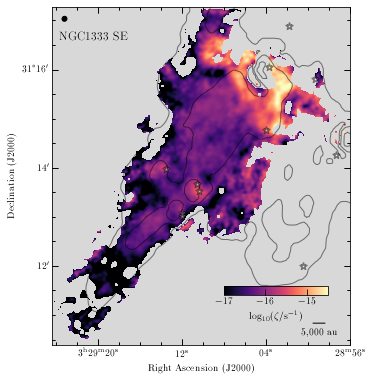

In [26]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(np.log10(zeta), hd_TdV), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-17, vmax=-14.5, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(\zeta/{\rm s^{-1}})$', orientation='horizontal')
# cbar.set_ticks([-19, -18, -17])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_Zeta.pdf', dpi=200, bbox_inches='tight')

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


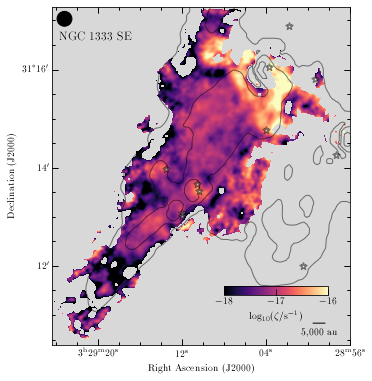

In [27]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(np.log10(zeta_mean_n), hd_fd), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-18, vmax=-16, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(\zeta/ {\rm s^{-1}})$', orientation='horizontal')
# cbar.set_ticks([-19, -18, -17])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_Zeta_mean_n.pdf', dpi=200, bbox_inches='tight')

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


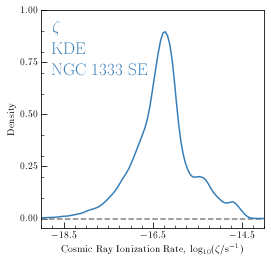

In [28]:
log_zeta = np.log10(zeta)

xrange = np.array([-19, -14])

gd_zeta = np.isfinite(log_zeta)
# wt = 1 / NH3_dv[log_xe]**2
#
kde_log_zeta = stats.gaussian_kde(log_zeta[gd_zeta])#, weights=wt)
x_sample = np.linspace(xrange[0], xrange[1], num=100)
log_zeta_sample = np.reshape(kde_log_zeta(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, log_zeta_sample, color=color_kde[1])
#
ax.text(0.05, 0.9,  r'$\zeta$', color=color_kde[1],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.8,  r'KDE', color=color_kde[1],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.7,  r'NGC 1333 SE', color=color_kde[1],
        transform=ax.transAxes, size=17, weight=60)

#ax.set_xlabel(r"Cosmic rate, $\log_{10}(\zeta)$")
ax.set_xlabel(r"Cosmic Ray Ionization Rate, $\log_{10}(\zeta / {\rm s^{-1}})$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)
# ax.set_ylim(-0.02, 0.8)

ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xticks([-18.5, -16.5, -14.5])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])

fig.savefig('figs/NGC1333_log_zeta_KDE.pdf', dpi=100, bbox_inches='tight')

In [29]:
log_zeta_min = -19
log_zeta_max = -14

log_H2_min = 21.5
log_H2_max = 24.0

# log_H2 = np.log10(N_H2.value)
# hdu_log10_h2

gd_map = np.isfinite( 1./ (hdu_log10_h2.data * log_zeta))
my_X = hdu_log10_h2.data[gd_map]
my_Y = log_zeta[gd_map]

xx_log_H2_zeta, yy_log_H2_zeta = np.mgrid[log_H2_min:log_H2_max:100j, log_zeta_min:log_zeta_max:100j]
positions = np.vstack([xx_log_H2_zeta.ravel(), yy_log_H2_zeta.ravel()])
values = np.vstack([my_X, my_Y])

kernel_log_H2_zeta = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_log_H2_zeta(positions).T, xx_log_H2_zeta.shape)

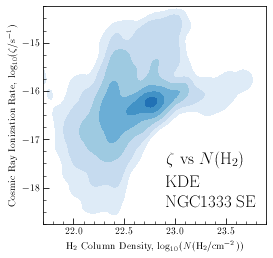

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_log_H2_zeta, yy_log_H2_zeta, 
                    my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())

ax.set_xlabel(r"H$_2$ Column Density, $\log_{10}(N({\rm H_2 /cm^{-2}}))$")
ax.set_ylabel(r"Cosmic Ray Ionization Rate, $\log_{10}(\zeta / {\rm s^{-1}})$")

ax.text(0.55, 0.075,  r'NGC1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.175,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.275,  r'$\zeta$ vs $N({\rm H_2})$', color='black', 
        transform=ax.transAxes, size=17, weight=60)

ax.set_xlim([21.7, 23.9])
ax.set_ylim([-18.75, -14.25])
#
#
# Setup for Ticks
#
ax.set_xticks([22, 22.5, 23., 23.5])
ax.set_yticks([-18, -17, -16, -15])
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
#
fig.savefig('figs/NGC1333_log_zeta_log_N_H2_KDE.pdf', dpi=100, bbox_inches='tight')

[]

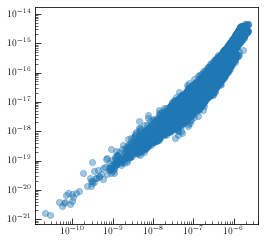

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(xe_fd[gd_zeta], zeta[gd_zeta], alpha=0.4)
plt.loglog()